In [1]:
%matplotlib inline  

In [42]:
import torch
import pandas as pd
import numpy as np
import math
import matplotlib.pylab as plt
import matplotlib as mpl

import os
import sys

In [3]:
os.chdir("..")

In [39]:
from optbnn.gp.models.gpr import GPR
from optbnn.gp import kernels, mean_functions, priors
from optbnn.bnn.reparam_nets import GaussianMLPReparameterization
from optbnn.bnn.nets.mlp import MLP
from optbnn.bnn.likelihoods import LikGaussian
from optbnn.bnn.priors import FixedGaussianPrior, OptimGaussianPrior
from optbnn.prior_mappers.wasserstein_mapper import MapperWasserstein, WassersteinDistance
from optbnn.utils.rand_generators import MeasureSetGenerator, GridGenerator
from optbnn.utils.normalization import normalize_data
from optbnn.utils.exp_utils import get_input_range
from optbnn.metrics.sampling import compute_rhat_regression
from optbnn.metrics import uncertainty as uncertainty_metrics
from optbnn.sgmcmc_bayes_net.regression_net import RegressionNet
from optbnn.utils import util

In [18]:
mpl.rcParams['figure.dpi'] = 100

In [5]:
SEED = 123
util.set_seed(SEED)

In [6]:
# Network architecture
n_units = 100
n_hidden = 1
activation_fn = "tanh"

In [7]:
# Dataset configurations
n_splits = 10
dataset = "boston"
data_dir = "./data/uci"
noise_var = 0.1

# 1. Optimized Gaussian Prior

In [8]:
out_dir = "./exp/uci/optim_gaussian"
util.ensure_dir(out_dir)

## 1.1 Optimize the prior

In [9]:
num_iters = 200  # Number of iteterations of Wasserstein optimization
lr = 0.05        # The learning rate
n_samples = 128  # The mini-batch size

In [10]:
for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id, dataset))
    # Load the dataset
    saved_dir = os.path.join(out_dir, str(split_id))
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    X_train_, y_train_, X_test_, y_test_, y_mean, y_std = normalize_data(
            X_train, y_train, X_test, y_test)
    x_min, x_max = get_input_range(X_train_, X_test_)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the measurement set generator
    rand_generator = MeasureSetGenerator(X_train_, x_min, x_max, 0.7)
    
    # Initialize the mean and covariance function of the target hierarchical GP prior
    mean = mean_functions.Zero()
    
    lengthscale = math.sqrt(2. * input_dim)
    variance = 1.
    kernel = kernels.RBF(input_dim=input_dim,
                         lengthscales=torch.tensor([lengthscale], dtype=torch.double),
                         variance=torch.tensor([variance], dtype=torch.double), ARD=True)

    # Place hyper-priors on lengthscales and variances
    kernel.lengthscales.prior = priors.LogNormal(
            torch.ones([input_dim]) * math.log(lengthscale),
            torch.ones([input_dim]) * 1.)
    kernel.variance.prior = priors.LogNormal(
            torch.ones([1]) * 0.1,
            torch.ones([1]) * 1.)
        
    # Initialize the GP model
    gp = GPR(X=torch.from_numpy(X_train_), Y=torch.from_numpy(y_train_).reshape([-1, 1]),
             kern=kernel, mean_function=mean)
    gp.likelihood.variance.set(noise_var)
    
    # Initialize tunable MLP prior
    hidden_dims = [n_units] * n_hidden
    mlp_reparam = GaussianMLPReparameterization(input_dim, output_dim,
        hidden_dims, activation_fn, scaled_variance=True)
    
    mapper = MapperWasserstein(gp, mlp_reparam, rand_generator, out_dir=saved_dir,
                               output_dim=output_dim, n_data=100,
                               wasserstein_steps=(0, 200),
                               wasserstein_lr=0.02,
                               logger=None, wasserstein_thres=0.1,
                               n_gpu=0, gpu_gp=False)
    
    w_hist = mapper.optimize(num_iters=num_iters, n_samples=n_samples,
                             lr=lr, print_every=10, save_ckpt_every=10, debug=True)
    path = os.path.join(saved_dir, "wsr_values.log")
    np.savetxt(path, w_hist, fmt='%.6e')
    print("----" * 20)

Loading split 0 of boston dataset
>>> Iteration #   1: Wasserstein Dist 11.1247
>>> Iteration #  10: Wasserstein Dist 4.0591
>>> Iteration #  20: Wasserstein Dist 2.9549
>>> Iteration #  30: Wasserstein Dist 4.4276
>>> Iteration #  40: Wasserstein Dist 3.8298
>>> Iteration #  50: Wasserstein Dist 2.5937
>>> Iteration #  60: Wasserstein Dist 3.3104
>>> Iteration #  70: Wasserstein Dist 1.5923
>>> Iteration #  80: Wasserstein Dist 2.4809
>>> Iteration #  90: Wasserstein Dist 1.8494
>>> Iteration # 100: Wasserstein Dist 2.6735
>>> Iteration # 110: Wasserstein Dist 1.8528
>>> Iteration # 120: Wasserstein Dist 1.8654
>>> Iteration # 130: Wasserstein Dist 1.6288
>>> Iteration # 140: Wasserstein Dist 1.7169
>>> Iteration # 150: Wasserstein Dist 2.2507
>>> Iteration # 160: Wasserstein Dist 2.1141
>>> Iteration # 170: Wasserstein Dist 0.6198
>>> Iteration # 180: Wasserstein Dist 0.8857
>>> Iteration # 190: Wasserstein Dist 2.3736
>>> Iteration # 200: Wasserstein Dist 1.2547
Saved intermediate w

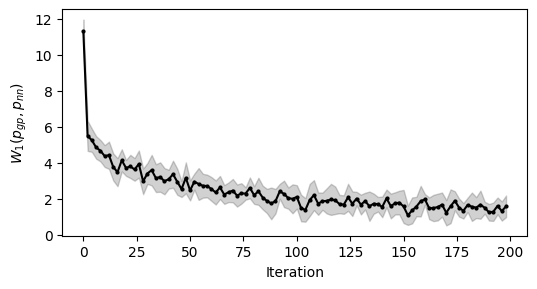

In [28]:
# Visualize the convergence
wdist_data = []
for i in range(0, n_splits):
    wdist_file = os.path.join(out_dir, str(i), "wsr_values.log")
    wdist_data.append(np.loadtxt(wdist_file))

wdist_vals = np.stack(wdist_data)
x = np.arange(wdist_vals.shape[1])
mean = wdist_vals.mean(0)
std = wdist_vals.std(0)

fig = plt.figure(figsize=(6, 3))
plt.plot(x[::2], mean[::2], "-ok", ms=2)
plt.fill_between(x[::2], mean[::2] - std[::2],
                 mean[::2] + std[::2], alpha=0.18, color="k")
plt.xlabel("Iteration")
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.show()

## 1.2 Posterior Inference

In [29]:
# Configure the SGHMC sampler
sampling_configs = {
    "batch_size": 32,
    "num_samples": 40,
    "n_discarded": 10,
    "num_burn_in_steps": 2000,
    "keep_every": 2000,
    "lr": 1e-2,
    "num_chains": 4,
    "mdecay": 1e-2,
    "print_every_n_samples": 5
}

In [41]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the neural network and likelihood modules
    net = MLP(input_dim, output_dim, [n_units] * n_hidden, activation_fn)
    likelihood = LikGaussian(noise_var)
    
    # Load the optimized prior
    ckpt_path = os.path.join(out_dir, str(split_id), "ckpts", "it-{}.ckpt".format(num_iters))
    prior = OptimGaussianPrior(ckpt_path)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 0 of boston dataset
Chain: 0
Samples #     5 : NLL =  2.2758e+00 RMSE = 1.8902e+00 
Samples #    10 : NLL =  2.2691e+00 RMSE = 1.7746e+00 
Samples #    15 : NLL =  2.2656e+00 RMSE = 1.7515e+00 
Samples #    20 : NLL =  2.2697e+00 RMSE = 1.7667e+00 
Samples #    25 : NLL =  2.2691e+00 RMSE = 1.7631e+00 
Samples #    30 : NLL =  2.2702e+00 RMSE = 1.7571e+00 
Chain: 1
Samples #    35 : NLL =  2.2705e+00 RMSE = 1.7514e+00 
Samples #    40 : NLL =  2.2693e+00 RMSE = 1.7497e+00 
Samples #    45 : NLL =  2.2678e+00 RMSE = 1.7410e+00 
Samples #    50 : NLL =  2.2673e+00 RMSE = 1.7387e+00 
Samples #    55 : NLL =  2.2660e+00 RMSE = 1.7337e+00 
Samples #    60 : NLL =  2.2660e+00 RMSE = 1.7334e+00 
Chain: 2
Samples #    65 : NLL =  2.2664e+00 RMSE = 1.7351e+00 
Samples #    70 : NLL =  2.2668e+00 RMSE = 1.7368e+00 
Samples #    75 : NLL =  2.2681e+00 RMSE = 1.7370e+00 
Samples #    80 : NLL =  2.2680e+00 RMSE = 1.7355e+00 
Samples #    85 : NLL =  2.2677e+00 RMSE = 1.7336e+00 
Samp

In [45]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir, "optim_results.csv"), sep="\t", index=False)

In [46]:
print("Final results")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df['rmse'].mean()), float(result_df['rmse'].std()),
        float(result_df['nll'].mean()), float(result_df['nll'].std())))

Final results
> RMSE: mean 2.7970e+00; std 9.1485e-01 | NLL: mean 2.4699e+00 std 1.4601e-01


# 2. Standard Gaussian Prior

In [47]:
results = {"rmse": [], "nll": []}

for split_id in range(n_splits):
    print("Loading split {} of {} dataset".format(split_id, dataset))
    saved_dir = os.path.join(out_dir, str(split_id))
    
    # Load the dataset
    X_train, y_train, X_test, y_test = util.load_uci_data(
            data_dir, split_id, dataset)
    input_dim, output_dim = int(X_train.shape[-1]), 1
    
    # Initialize the neural network and likelihood modules
    net = MLP(input_dim, output_dim, [n_units] * n_hidden, activation_fn)
    likelihood = LikGaussian(noise_var)
    
    # Initialize the standard gaussian prior
    prior = FixedGaussianPrior(std=1.0)
    
    # Initialize bayesian neural network with SGHMC sampler
    saved_dir = os.path.join(out_dir, str(split_id))
    bayes_net = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)
    
    # Start sampling
    bayes_net.sample_multi_chains(X_train, y_train, **sampling_configs)
    pred_mean, pred_var, preds, raw_preds = bayes_net.predict(X_test, True, True)
    r_hat = compute_rhat_regression(raw_preds, sampling_configs["num_chains"])
    print("R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))

    rmse = uncertainty_metrics.rmse(pred_mean, y_test)
    nll = uncertainty_metrics.gaussian_nll(y_test, pred_mean, pred_var)
    print("> RMSE = {:.4f} | NLL = {:.4f}".format(rmse, nll))
    results['rmse'].append(rmse)
    results['nll'].append(nll)

Loading split 0 of boston dataset
Chain: 0
Samples #     5 : NLL =  2.4463e+00 RMSE = 2.7549e+00 
Samples #    10 : NLL =  2.4335e+00 RMSE = 2.7280e+00 
Samples #    15 : NLL =  2.4278e+00 RMSE = 2.7117e+00 
Samples #    20 : NLL =  2.4211e+00 RMSE = 2.6928e+00 
Samples #    25 : NLL =  2.4226e+00 RMSE = 2.7005e+00 
Samples #    30 : NLL =  2.4209e+00 RMSE = 2.6855e+00 
Chain: 1
Samples #    35 : NLL =  2.4237e+00 RMSE = 2.6917e+00 
Samples #    40 : NLL =  2.4231e+00 RMSE = 2.6914e+00 
Samples #    45 : NLL =  2.4221e+00 RMSE = 2.6894e+00 
Samples #    50 : NLL =  2.4220e+00 RMSE = 2.6891e+00 
Samples #    55 : NLL =  2.4198e+00 RMSE = 2.6845e+00 
Samples #    60 : NLL =  2.4207e+00 RMSE = 2.6863e+00 
Chain: 2
Samples #    65 : NLL =  2.4220e+00 RMSE = 2.6874e+00 
Samples #    70 : NLL =  2.4218e+00 RMSE = 2.6851e+00 
Samples #    75 : NLL =  2.4213e+00 RMSE = 2.6863e+00 
Samples #    80 : NLL =  2.4212e+00 RMSE = 2.6887e+00 
Samples #    85 : NLL =  2.4204e+00 RMSE = 2.6864e+00 
Samp

In [48]:
result_df = pd.DataFrame(results)
result_df.to_csv(os.path.join(out_dir, "std_results.csv"), sep="\t", index=False)

In [49]:
print("Final results")
print("> RMSE: mean {:.4e}; std {:.4e} | NLL: mean {:.4e} std {:.4e}".format(
        float(result_df['rmse'].mean()), float(result_df['rmse'].std()),
        float(result_df['nll'].mean()), float(result_df['nll'].std())))

Final results
> RMSE: mean 3.1317e+00; std 1.0602e+00 | NLL: mean 2.5668e+00 std 3.0216e-01
